# Import and prepare Notebook Environement

In [7]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix, accuracy_score
from imblearn.over_sampling import RandomOverSampler

In [8]:
sys.path.append(os.path.abspath("../../../src/"))

In [9]:
from EmbVector import Vector

## **Models**
## Getting datas
**clean_art mode** : The "Sum" colum of datas is the sum of all word vector from the cleaned article having preprocessing. 

In [10]:
def get_model(is_balanced):
    if is_balanced:
        path = "../../../datas/skipgram_A3316_WS20_E20_B10000_R2000_CTrue.model"
    else:
        path = "../../../datas/skipgram_3284.model"
    return path

In [11]:
datas = Vector(data_file = "../../../datas/training_clean", 
        model_path = get_model(is_balanced = True), 
        is_training = True)
# type_sum values : gene_var, best_sim, clean_art, sim_gene_var
# top_number only use with best_sim or sim_gene_var, defautl = 50
datas.get_vector_datas(is_notebook = True, type_sum =  "clean_art")

________________________Getting datas vectors_______________________
____________________________________________________________________
Number of genes/variations not foud : 688
Number of article words not foud : 189
____________________________________________________________________
Getting vectors finished in 39.94069137800034 seconds


In [12]:
datas_unbalanced = Vector(data_file = "../../../datas/training_clean", 
        model_path = get_model(is_balanced = False), 
        is_training = True)
# type_sum values : gene_var, best_sim, clean_art, sim_gene_var
# top_number only use with best_sim or sim_gene_var, defautl = 50
datas_unbalanced.get_vector_datas(is_notebook = True, type_sum =  "clean_art")

________________________Getting datas vectors_______________________
____________________________________________________________________
Number of genes/variations not foud : 841
Number of article words not foud : 104617
____________________________________________________________________
Getting vectors finished in 57.62053835600091 seconds


## Split the datas
Spliting the datas from the first model (without new articles) by 80% for training, and 20% fort test

In [13]:
X = datas.vectors[['Gene','Variation','Sum']]
Y = pd.get_dummies(datas.vectors["Class"]).values

#X = datas_unbalanced.vectors[['Gene','Variation','Sum']]
#Y = pd.get_dummies(datas_unbalanced.vectors["Class"]).values

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, stratify=Y)
print("X_train : " + str(X_train.shape))
print("Y_train : " + str(Y_train.shape))
print("X_test : " + str(X_test.shape))
print("Y_test : " + str(Y_test.shape))

X_train : (2651, 3)
Y_train : (2651, 9)
X_test : (663, 3)
Y_test : (663, 9)


## Over Sampling

In [15]:
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')

# fit and apply the transform
X_train, Y_train = oversample.fit_resample(X_train, Y_train)
X_train, Y_train = oversample.fit_resample(X_train, Y_train)

print(X_train.shape)
print(Y_train.shape)

(4128, 3)
(4128, 9)


## Models : datas separated
Using all Gene, Variation, Sum datas but separated into different variable

In [16]:
X_train_gene = X_train["Gene"]
X_train_var = X_train["Variation"]
X_train_sum = X_train["Sum"]
X_test_gene = X_test["Gene"]
X_test_var = X_test["Variation"]
X_test_sum = X_test["Sum"]

In [17]:
X_train_gene = X_train_gene.values.reshape(X_train_gene.shape[0], 1)
X_train_var = X_train_var.values.reshape(X_train_var.shape[0], 1)
X_train_sum = X_train_sum.values.reshape(X_train_sum.shape[0], 1)

X_test_gene = X_test_gene.values.reshape(X_test_gene.shape[0], 1)
X_test_var = X_test_var.values.reshape(X_test_var.shape[0], 1)
X_test_sum = X_test_sum.values.reshape(X_test_sum.shape[0], 1)

## Preparing the datas for the input of the model
It is needed to convert the datas to have a clean numpy array and not a mix of object dataframe and array

In [18]:
def convert_to_np_gene(Object):
    np_list = []
    for obj in Object:
        cop = obj[0].copy()
        np_list.append(np.array(cop))
    return np.array(np_list)

def convert_to_np_var_sum(Object):
    np_list = []
    for obj in Object:
        for o in obj:
            cop = o[0].copy()
            np_list.append(np.array(cop))
    return np.array(np_list)

In [19]:
X_train_gene = convert_to_np_gene(X_train_gene)
X_train_var = convert_to_np_var_sum(X_train_var)
X_train_sum = convert_to_np_var_sum(X_train_sum)

X_test_gene = convert_to_np_gene(X_test_gene)
X_test_var = convert_to_np_var_sum(X_test_var)
X_test_sum = convert_to_np_var_sum(X_test_sum)

In [20]:
print("X_train_gene : " + str(X_train_gene.shape))
print("X_train_var : " + str(X_train_var.shape))
print("X_train_sum : " + str(X_train_sum.shape))

print("X_test_gene : " + str(X_test_gene.shape))
print("X_test_var : " + str(X_test_var.shape))
print("X_test_sum : " + str(X_test_sum.shape))

print("Y_train : " + str(Y_train.shape))
print("Y_test : " + str(Y_test.shape))

X_train_gene : (4128, 100)
X_train_var : (4128, 100)
X_train_sum : (4128, 100)
X_test_gene : (663, 100)
X_test_var : (663, 100)
X_test_sum : (663, 100)
Y_train : (4128, 9)
Y_test : (663, 9)


In [21]:
X_train_gene = X_train_gene.reshape(X_train_gene.shape[0],X_train_gene.shape[1], 1)
X_train_var = X_train_var.reshape(X_train_var.shape[0], X_train_var.shape[1], 1)
X_train_sum = X_train_sum.reshape(X_train_sum.shape[0], X_train_sum.shape[1], 1)

X_test_gene = X_test_gene.reshape(X_test_gene.shape[0], X_test_gene.shape[1], 1)
X_test_var = X_test_var.reshape(X_test_var.shape[0], X_test_var.shape[1], 1)
X_test_sum = X_test_sum.reshape(X_test_sum.shape[0], X_test_sum.shape[1], 1)

In [22]:
print("X_train_gene : " + str(X_train_gene.shape))
print("X_train_var : " + str(X_train_var.shape))
print("X_train_sum : " + str(X_train_sum.shape))

print("X_test_gene : " + str(X_test_gene.shape))
print("X_test_var : " + str(X_test_var.shape))
print("X_test_sum : " + str(X_test_sum.shape))

print("Y_train : " + str(Y_train.shape))
print("Y_test : " + str(Y_test.shape))

X_train_gene : (4128, 100, 1)
X_train_var : (4128, 100, 1)
X_train_sum : (4128, 100, 1)
X_test_gene : (663, 100, 1)
X_test_var : (663, 100, 1)
X_test_sum : (663, 100, 1)
Y_train : (4128, 9)
Y_test : (663, 9)


## **Building short model with Gene, Variation and Sum datas**

## Model 1 : One layer - softmax

In [23]:
def create_sm_simple():
    input_gene = layers.Input(shape=(X_train_gene.shape[1], X_train_gene.shape[2]))
    input_variant = layers.Input(shape=(X_train_var.shape[1], X_train_gene.shape[2]))
    input_sum = layers.Input(shape=(X_train_sum.shape[1], X_train_gene.shape[2]))

    input_2 = layers.Concatenate(axis = 1)([input_gene, input_variant, input_sum])
    flatten = layers.Flatten()(input_2)

    output = layers.Dense(9, activation='softmax')(flatten)

    return keras.Model(inputs = [input_gene, input_variant, input_sum], outputs = output)

2021-10-27 18:46:07.628051: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-27 18:46:07.628286: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-27 18:46:07.639547: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


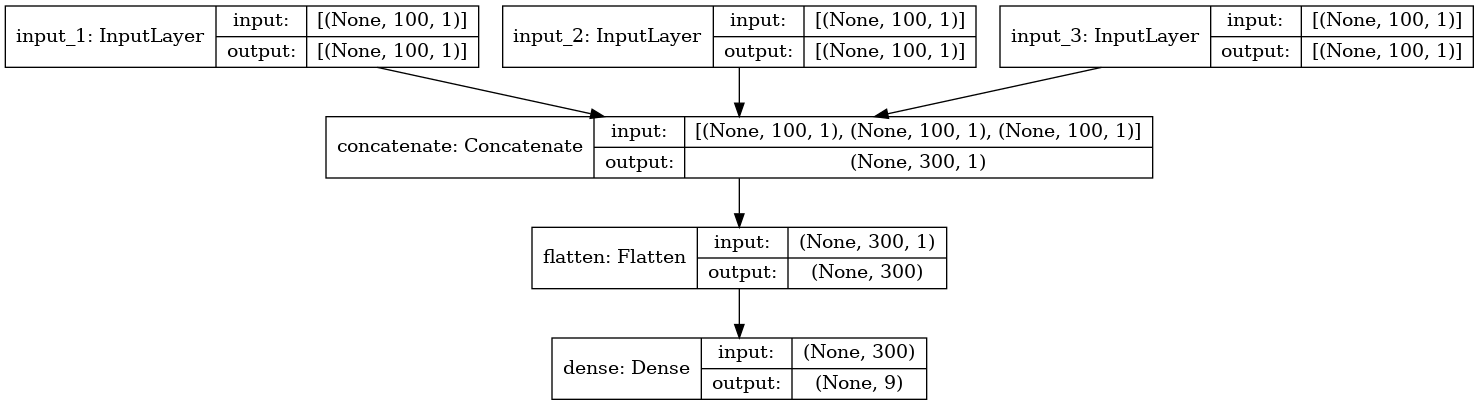

In [24]:
model_sm = create_sm_simple()
model_sm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
keras.utils.plot_model(model_sm, "SM_W2V_Separate_ca.png", show_shapes= True)

## Model 2 : Two layers - Dense Softmax

In [25]:
def create_dsm_simple():
    input_gene = layers.Input(shape=(X_train_gene.shape[1], X_train_gene.shape[2]))
    input_variant = layers.Input(shape=(X_train_var.shape[1], X_train_gene.shape[2]))
    input_sum = layers.Input(shape=(X_train_sum.shape[1], X_train_gene.shape[2]))

    input_2 = layers.Concatenate(axis = 1)([input_gene, input_variant, input_sum])

    dense = layers.Dense(16, activation='relu')(input_2)
    flatten = layers.Flatten()(dense)
    output = layers.Dense(9, activation='softmax')(flatten)

    return keras.Model(inputs = [input_gene, input_variant, input_sum], outputs = output)

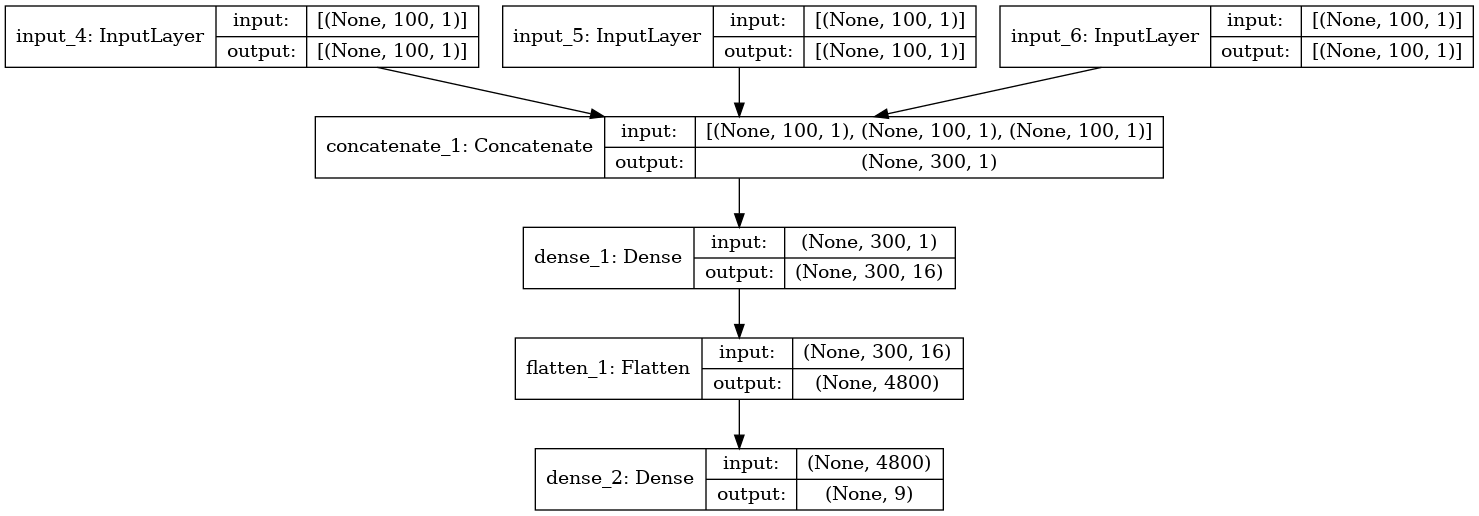

In [26]:
model_dsm = create_dsm_simple()
model_dsm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
keras.utils.plot_model(model_dsm, "DSM_W2V_Separate_ca.png", show_shapes= True)

## **Building CNN the model with Gene, Variation and Sum datas**

## Model 1 : Simple

In [27]:
def create_model_simple():
    input_gene = layers.Input(shape=(X_train_gene.shape[1], X_train_gene.shape[2]))
    input_variant = layers.Input(shape=(X_train_var.shape[1], X_train_gene.shape[2]))
    input_sum = layers.Input(shape=(X_train_sum.shape[1], X_train_gene.shape[2]))


    conv_gene = layers.Conv1D(32, kernel_size=(3), activation='relu')(input_gene)
    conv_var = layers.Conv1D(32, kernel_size=(3), activation='relu')(input_variant)
    conv_sum = layers.Conv1D(32, kernel_size=(3), activation='relu')(input_sum)

    input_2 = layers.Concatenate(axis = 1)([conv_gene, conv_var, conv_sum])

    dense_1 = layers.Dense(16, activation='relu')(input_2)
    flatten = layers.Flatten()(dense_1)
    output = layers.Dense(9, activation='softmax')(flatten)

    return keras.Model(inputs = [input_gene, input_variant, input_sum], outputs = output)

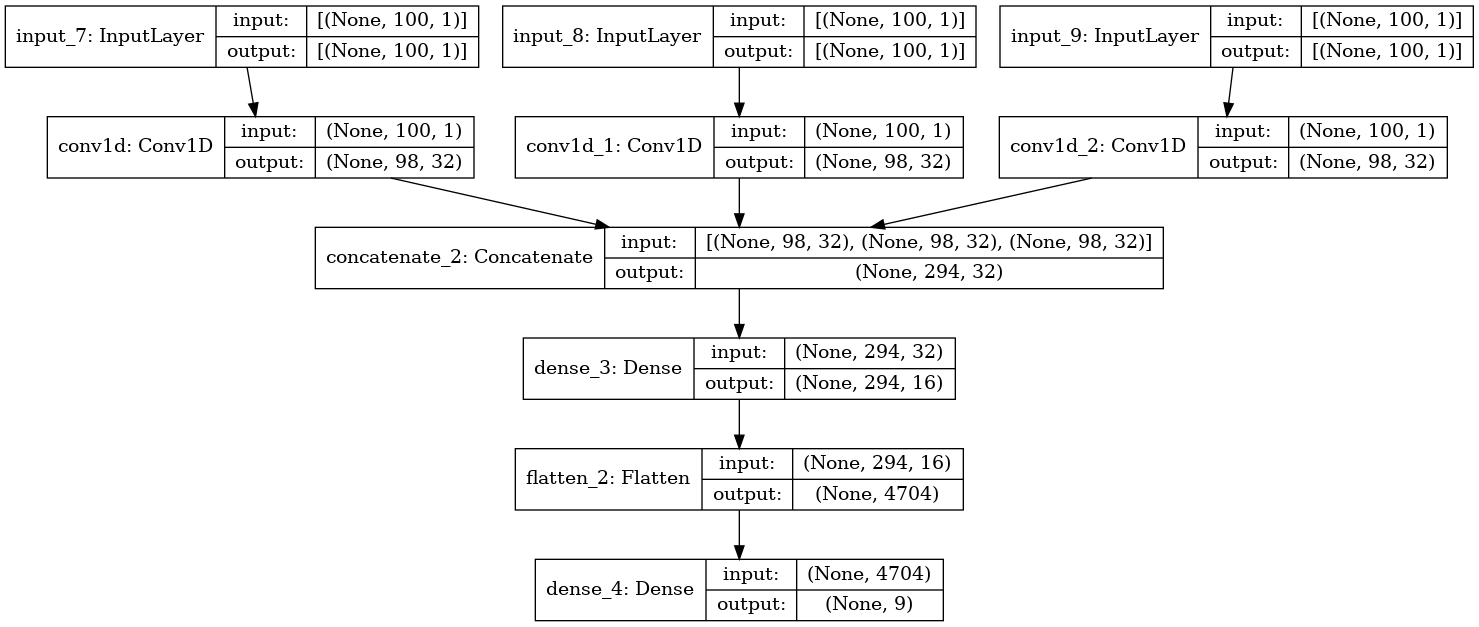

In [28]:
model_simple = create_model_simple()
model_simple.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
keras.utils.plot_model(model_simple, "CNN_W2V_Separate_Simple_ca.png", show_shapes= True)

## Model 2 : Complex

In [29]:
def create_model_complex():
    input_gene = layers.Input(shape=(X_train_gene.shape[1], X_train_gene.shape[2]))
    input_variant = layers.Input(shape=(X_train_var.shape[1], X_train_gene.shape[2]))
    input_sum = layers.Input(shape=(X_train_sum.shape[1], X_train_gene.shape[2]))
    
    
    conv_gene = layers.Conv1D(64, kernel_size=(3), activation='relu')(input_gene)
    conv_var = layers.Conv1D(64, kernel_size=(3), activation='relu')(input_variant)
    conv_sum = layers.Conv1D(64, kernel_size=(3), activation='relu')(input_sum)
    
    pool_gene = layers.GlobalMaxPooling1D()(conv_gene)
    pool_var = layers.GlobalMaxPooling1D()(conv_var)
    pool_sum = layers.GlobalMaxPooling1D()(conv_sum)
    
    
    dense_gene = layers.Dense(64, activation='relu')(pool_gene)
    dense_var = layers.Dense(64, activation='relu')(pool_var)
    dense_sum = layers.Dense(64, activation='relu')(pool_sum)
    
    
    input_2 = layers.Concatenate(axis = 1)([dense_gene, dense_var, dense_sum])
    dense = layers.Dense(32, activation='relu')(input_2)
    dense_1 = layers.Dense(16, activation='relu')(dense)
    flatten = layers.Flatten()(dense_1)
    output = layers.Dense(9, activation='softmax')(flatten)
    
    
    return keras.Model(inputs = [input_gene, input_variant, input_sum], outputs = output)

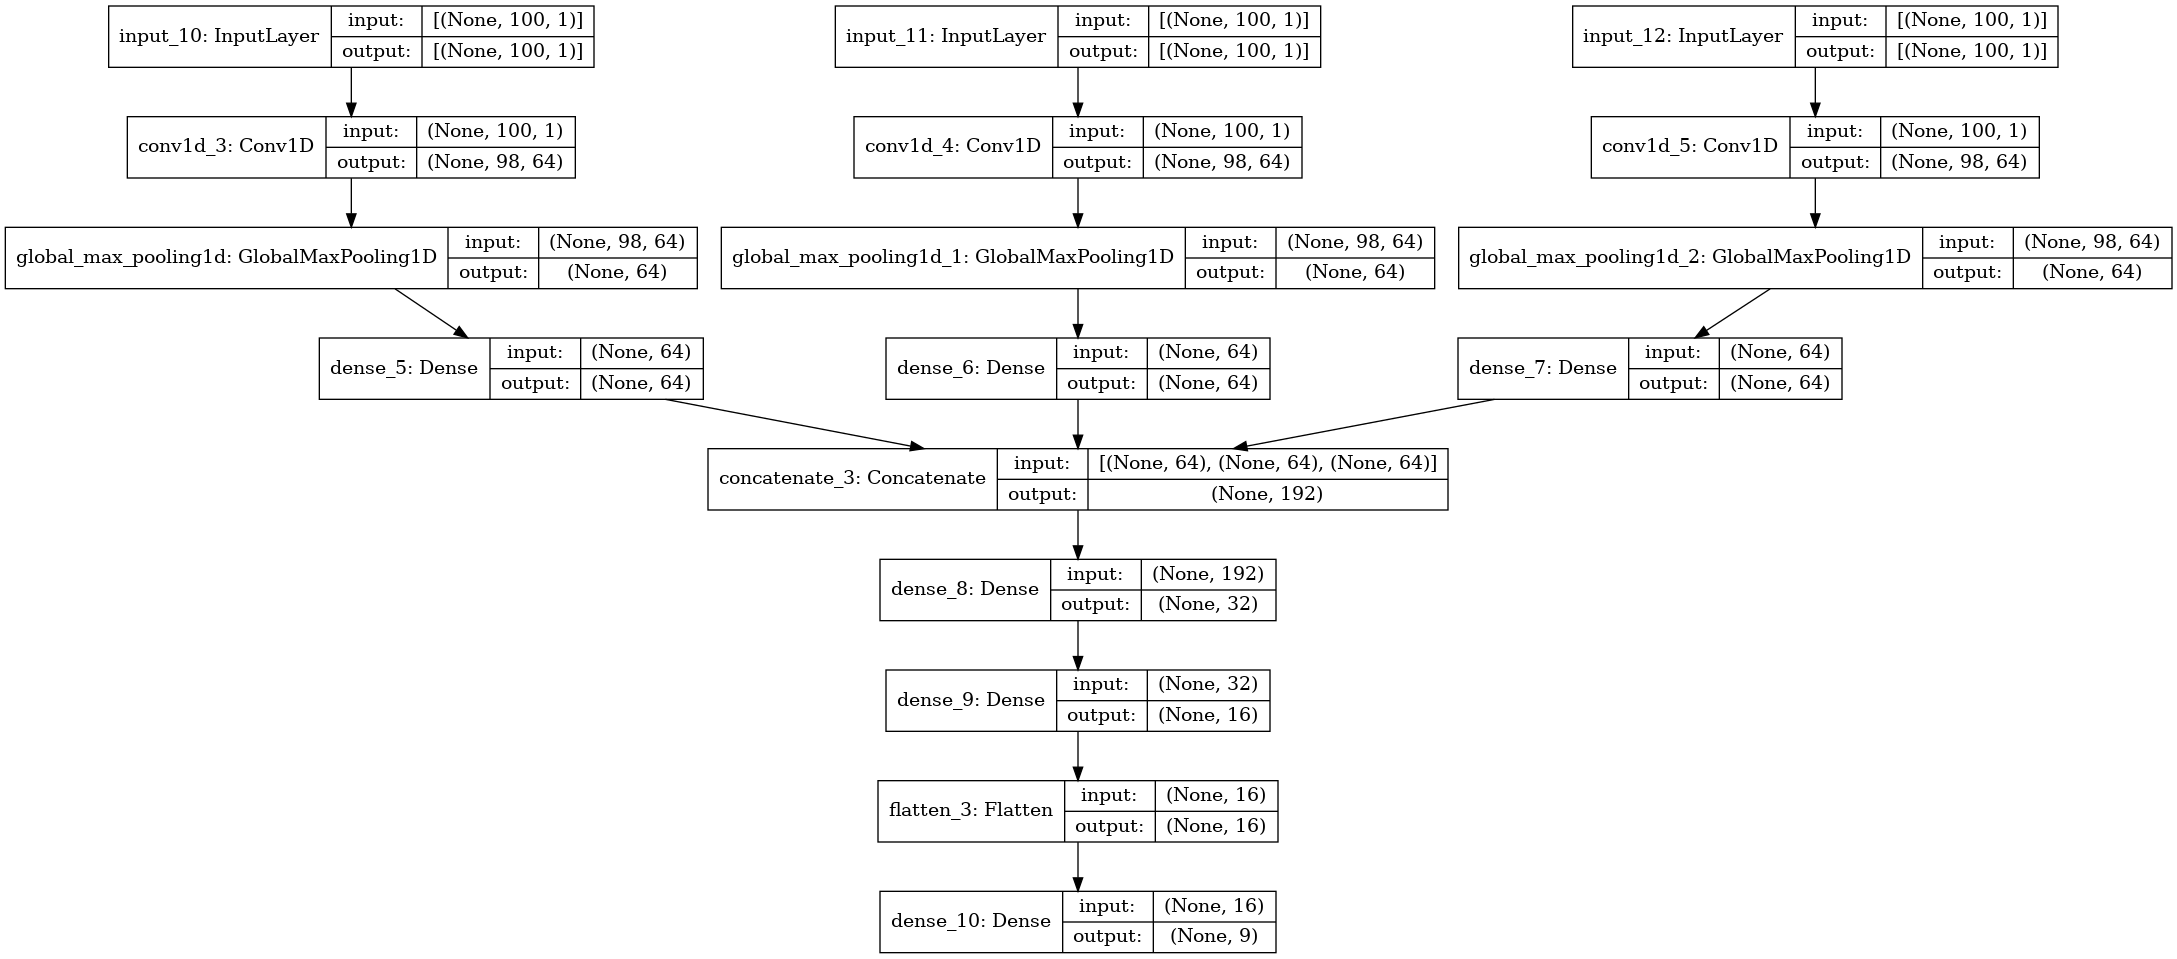

In [30]:
model_complex = create_model_complex()
model_complex.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
keras.utils.plot_model(model_complex, "CNN_W2V_Separate_Complex_ca.png", show_shapes= True)

## **Training**

## Short Model 1 : Softmax

In [31]:
history_sm = model_sm.fit([X_train_gene, X_train_var, X_train_sum], Y_train,
                     epochs=50,
                     verbose=False,
                     validation_split = 0.2,
                     batch_size= 32, 
                     callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
)

2021-10-27 18:46:08.742173: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-27 18:46:08.749361: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2803205000 Hz


In [32]:
loss, accuracy = model_sm.evaluate([X_train_gene, X_train_var, X_train_sum], Y_train, verbose=False)
print("Training Accuracy: %.3f %%"  % (accuracy * 100.0))

Training Accuracy: 40.964 %


In [33]:
loss, accuracy = model_sm.evaluate([X_test_gene, X_test_var, X_test_sum], Y_test, verbose=False)

print("Testing Accuracy:  %.3f %%"  % (accuracy * 100.0))

Testing Accuracy:  41.780 %


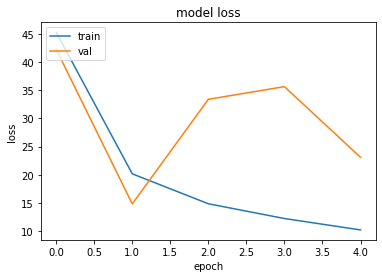

In [34]:
# summarize history for loss
plt.plot(history_sm.history['loss'])
plt.plot(history_sm.history['val_loss'])
plt.title("model loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

## Short Model 2 : Dense - Softmax

In [35]:
history_dsm = model_dsm.fit([X_train_gene, X_train_var, X_train_sum], Y_train,
                     epochs=50,
                     verbose=False,
                     validation_split = 0.2,
                     batch_size= 32, 
                     callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
)

In [36]:
loss, accuracy = model_dsm.evaluate([X_train_gene, X_train_var, X_train_sum], Y_train, verbose=False)
print("Training Accuracy: %.3f %%"  % (accuracy * 100.0))

Training Accuracy: 66.085 %


In [37]:
loss, accuracy = model_dsm.evaluate([X_test_gene, X_test_var, X_test_sum], Y_test, verbose=False)

print("Testing Accuracy:  %.3f %%"  % (accuracy * 100.0))

Testing Accuracy:  55.656 %


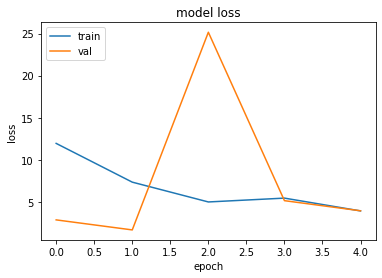

In [38]:
# summarize history for loss
plt.plot(history_dsm.history['loss'])
plt.plot(history_dsm.history['val_loss'])
plt.title("model loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

## CNN Model 1 : Simple

In [39]:
history_simple = model_simple.fit([X_train_gene, X_train_var, X_train_sum], Y_train,
                     epochs=50,
                     verbose=False,
                     validation_split = 0.2,
                     batch_size= 32, 
                     callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
)

In [40]:
loss, accuracy = model_simple.evaluate([X_train_gene, X_train_var, X_train_sum], Y_train, verbose=False)
print("Training Accuracy: %.3f %%"  % (accuracy * 100.0))

Training Accuracy: 85.102 %


In [41]:
loss, accuracy = model_simple.evaluate([X_test_gene, X_test_var, X_test_sum], Y_test, verbose=False)

print("Testing Accuracy:  %.3f %%"  % (accuracy * 100.0))

Testing Accuracy:  65.762 %


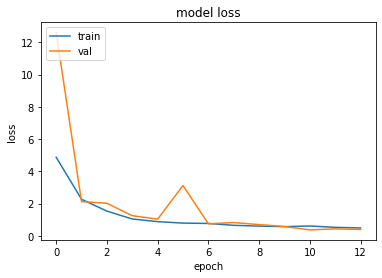

In [42]:
# summarize history for loss
plt.plot(history_simple.history['loss'])
plt.plot(history_simple.history['val_loss'])
plt.title("model loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

## CNN Model 2 : Complex

In [43]:
history_complex = model_complex.fit([X_train_gene, X_train_var, X_train_sum], Y_train,
                     epochs=50,
                     verbose=False,
                     validation_split = 0.2,
                     batch_size= 32, 
                     callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
)

In [44]:
loss, accuracy = model_complex.evaluate([X_train_gene, X_train_var, X_train_sum], Y_train, verbose=False)
print("Training Accuracy: %.3f %%"  % (accuracy * 100.0))

Training Accuracy: 26.914 %


In [45]:
loss, accuracy = model_complex.evaluate([X_test_gene, X_test_var, X_test_sum], Y_test, verbose=False)

print("Testing Accuracy:  %.3f %%"  % (accuracy * 100.0))

Testing Accuracy:  34.842 %


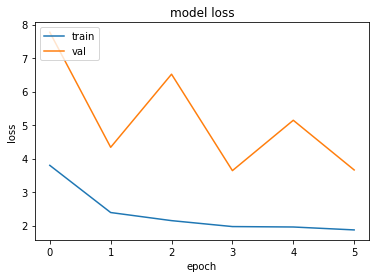

In [46]:
# summarize history for loss
plt.plot(history_complex.history['loss'])
plt.plot(history_complex.history['val_loss'])
plt.title("model loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

## **Saving models**

In [47]:
model_sm.save("../../../results/Models/skipgram_over_sampling/skipgram_os_sm_Separate_ca.model")

2021-10-27 18:46:46.091172: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../../../results/Models/skipgram_over_sampling/skipgram_os_sm_Separate_ca.model/assets


In [48]:
model_dsm.save("../../../results/Models/skipgram_over_sampling/skipgram_os_dsm_Separate_ca.model")

INFO:tensorflow:Assets written to: ../../../results/Models/skipgram_over_sampling/skipgram_os_dsm_Separate_ca.model/assets


In [49]:
model_simple.save("../../../results/Models/skipgram_over_sampling/skipgram_os_cnn_simple_Separate_ca.model")

INFO:tensorflow:Assets written to: ../../../results/Models/skipgram_over_sampling/skipgram_os_cnn_simple_Separate_ca.model/assets


In [50]:
model_complex.save("../../../results/Models/skipgram_over_sampling/skipgram_os_cnn_complex_Separate_ca.model")

INFO:tensorflow:Assets written to: ../../../results/Models/skipgram_over_sampling/skipgram_os_cnn_complex_Separate_ca.model/assets


# Clear the Session and delete model

In [51]:
keras.backend.clear_session()
del model_sm
del model_dsm
del model_simple
del model_complex

__________________________________

__________________________________

# **Confusion matrix**

In [52]:
def plot_matrices(model, x_test, y_test):
  probas = model.predict(x_test)
  pred_indices = np.argmax(probas, axis=1)
  classes = np.array(range(1, 10))
  preds = classes[pred_indices]
  print('Log loss: {}'.format(log_loss(classes[np.argmax(y_test, axis=1)], probas)))
  print('Accuracy: {}'.format(accuracy_score(classes[np.argmax(y_test, axis=1)], preds))) 

  confusion  = confusion_matrix(classes[np.argmax(y_test, axis=1)], preds)
  precision =(confusion/confusion.sum(axis=0))
  recall =(((confusion.T)/(confusion.sum(axis=1))).T)
  f,(ax1,ax2,ax3, axcb) = plt.subplots(1,4, gridspec_kw={'width_ratios':[1,1,1,0.08]},figsize=(22,6)) 
  labels = [1,2,3,4,5,6,7,8,9]

  # Confusion matrix 
  g1 = sns.heatmap(confusion,cbar=False,ax=ax1,annot=True, cmap="Blues", fmt=".3f", xticklabels=labels, yticklabels=labels,)
  g1.set_ylabel('Original Class')
  g1.set_xlabel('Predicted Class')
  g1.set_title('Confusion') 

  # Precision matrix 
  g2 = sns.heatmap(precision,cmap="Blues",cbar=False,ax=ax2, annot=True,fmt=".3f", xticklabels=labels, yticklabels=labels)
  g2.set_ylabel('Original Class')
  g2.set_xlabel('Predicted Class')
  g2.set_yticks(labels)
  g2.set_title('Precision') 

  # Recall matrix 
  g3 = sns.heatmap(recall,cmap="Blues",ax=ax3, cbar_ax=axcb, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
  g3.set_ylabel('Original Class')
  g3.set_xlabel('Predicted Class')
  g3.set_title('Recall')
  g3.set_yticks(labels) 

  for ax in [g1,g2,g3]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=0)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)
  
  plt.show()


In [53]:
model_sm = keras.models.load_model("../../../results/Models/skipgram_over_sampling/skipgram_os_sm_Separate_ca.model")
model_dsm = keras.models.load_model("../../../results/Models/skipgram_over_sampling/skipgram_os_dsm_Separate_ca.model")

model_simple = keras.models.load_model("../../../results/Models/skipgram_over_sampling/skipgram_os_cnn_simple_Separate_ca.model")
model_complex = keras.models.load_model("../../../results/Models/skipgram_over_sampling/skipgram_os_cnn_complex_Separate_ca.model")

Log loss: 8.003188133713742
Accuracy: 0.4177978883861237


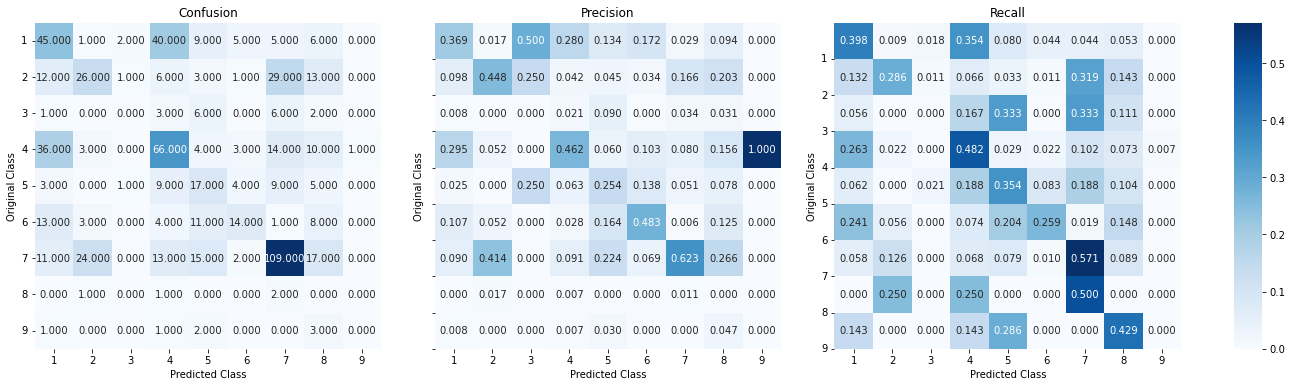

In [54]:
plot_matrices(model_sm, [X_test_gene, X_test_var, X_test_sum], Y_test)

Log loss: 3.5864114006600176
Accuracy: 0.5565610859728507


/tmp/ipykernel_38959/3591071593.py:10: RuntimeWarning: invalid value encountered in true_divide
  precision =(confusion/confusion.sum(axis=0))


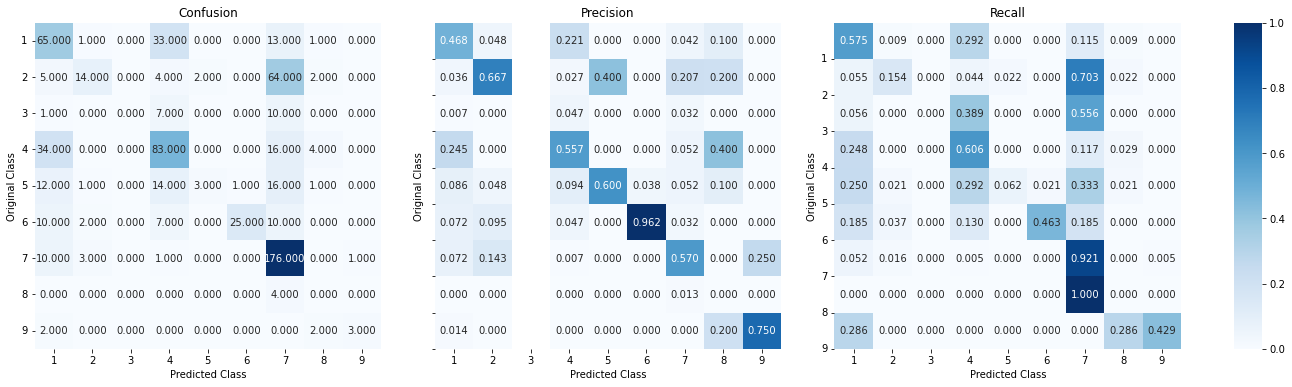

In [55]:
plot_matrices(model_dsm, [X_test_gene, X_test_var, X_test_sum], Y_test)

Log loss: 1.237352652562042
Accuracy: 0.6576168929110106


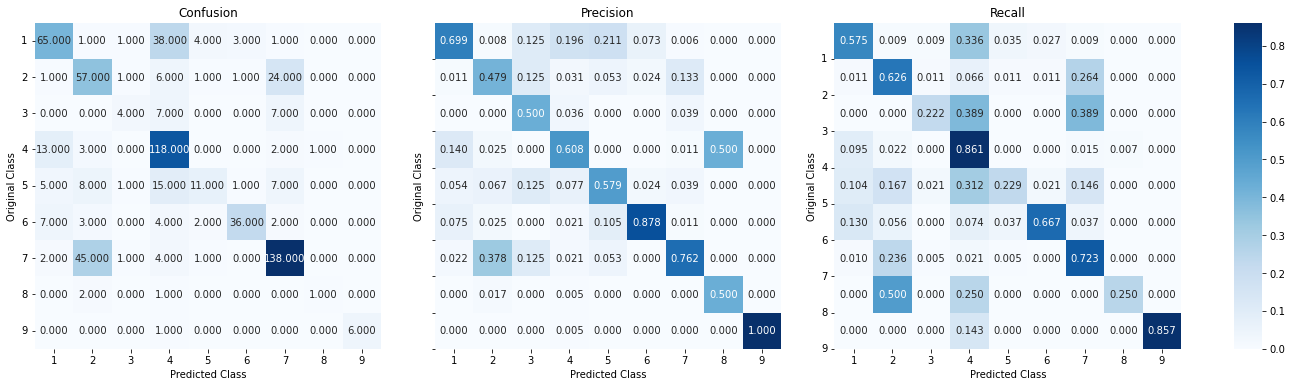

In [56]:
plot_matrices(model_simple, [X_test_gene, X_test_var, X_test_sum], Y_test)

Log loss: 1.8661647422174568
Accuracy: 0.34841628959276016


/tmp/ipykernel_38959/3591071593.py:10: RuntimeWarning: invalid value encountered in true_divide
  precision =(confusion/confusion.sum(axis=0))


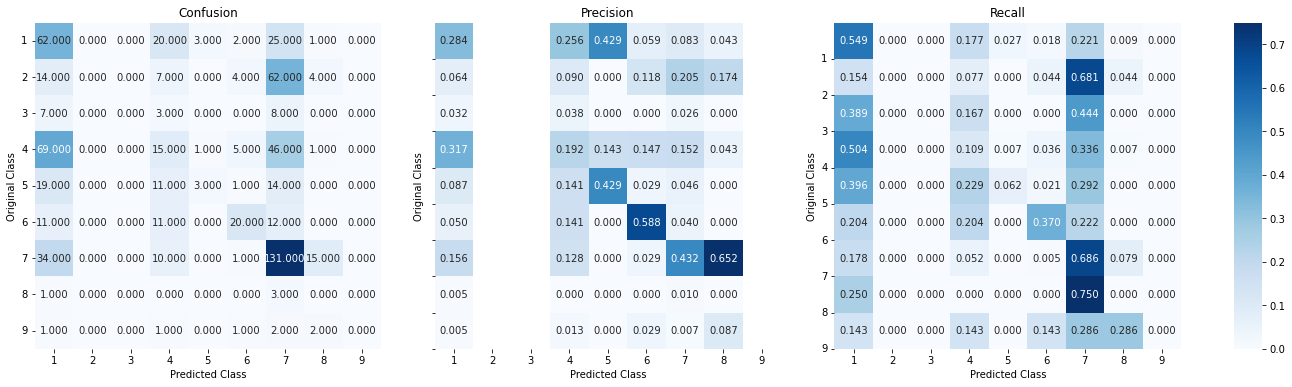

In [57]:
plot_matrices(model_complex, [X_test_gene, X_test_var, X_test_sum], Y_test)